In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns # started with this, but it didn't suit my needs, but kept to practise 
import matplotlib.pyplot as plt
from pprint import pprint
import plotly.express as px

In [ ]:

# Load difficulty_df and players from CSV file
difficulty_df = pd.read_csv('player_difficulty_data.csv')
players_df = pd.read_csv('selected_player_teams_data.csv')


# Replace missing values in 'EventName' with 'Gameweek 18'. It was loading weird and causing issues for calculations. 
difficulty_df['EventName'].fillna('Gameweek 18', inplace=True)

# Pivot the DataFrame to match players_df. Will join later
pivot_df = difficulty_df.pivot(index='PlayerID', columns='EventName', values='Difficulty')

# sort vals
pivot_df_sorted = pivot_df.sort_values(by='PlayerID', ascending=True)

# reset index to make PlayerID a regular column. had issues without doing this
pivot_df.reset_index(inplace=True)

#join these boys together. Now can start to predict future performance based on past performance
full_df =  pd.merge(left=players_df, right=pivot_df, how='left', left_on='id_player', right_on='PlayerID')


#print(full_df.head())
#print(full_df.info())


In [ ]:
# Changing the position code to shorthand for clear referencing
element_mapping = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
full_df["element_type"] = full_df["element_type"].replace(element_mapping)

# Rename to as element_type wasn't clear
full_df = full_df.rename(columns={'element_type': 'position'})

In [ ]:
""" Now for some calculations. I was reading that form is a stat that FPL uses which is based on an aggregation of points from previous game weeks
as well as taking in consideration for ICT or impact, contribution and threat scores. Basically if the player is in good form of recent. 
Secondly, I took the difficulty rating for the upcoming 5 matches to give a score. Then divided this by form to make a metric for 'fixure difficulty'.
The higher the score, the more likely the player will perform and make points for the coming weeks. I tried with 3 games, but since only one sub is 
allowed per week, it was probably better to plan ahead for a while.
"""

# Had some negative values in form which was causing errors. Replace all neg vals with 0 instead
full_df["form_player"] = full_df["form_player"].clip(lower=0)

full_df["FD_index"] = (full_df["form_player"] / full_df[["Gameweek 18", "Gameweek 19", "Gameweek 20", "Gameweek 21", "Gameweek 22"]].sum(axis=1)).round(3)
# for easy visualisation without concering players form
full_df["Difficulty_score"] = full_df[["Gameweek 18", "Gameweek 19", "Gameweek 20", "Gameweek 21", "Gameweek 22"]].sum(axis=1).round(3)
# data gave weird names so was easier for me to recongnise some players this way
full_df['full_name'] = full_df['first_name'] + ' ' + full_df['second_name']



#print(full_df.head())


In [ ]:
# Sorting and filtering by position: Forwards
forwards_df = full_df[full_df['position'] == 'FWD']
sorted_forwards_df = forwards_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Midfielders
midfielders_df = full_df[full_df['position'] == 'MID']
sorted_midfielders_df = midfielders_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Defenders
defenders_df = full_df[full_df['position'] == 'DEF']
sorted_defenders_df = defenders_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])

# Sorting and filtering Goalkeepers
goalkeepers_df = full_df[full_df['position'] == 'GK']
sorted_goalkeepers_df = goalkeepers_df.sort_values(by=['FD_index', 'expected_goals', 'expected_assists'], ascending=[False, False, False])


# Display the resulting DataFrame
#print(sorted_forwards_df.head(15))
#print(sorted_midfielders_df.head(25))
#print(sorted_defenders_df.head())
#print(sorted_goalkeepers_df.head())

""" while this is all well and good, it doesn't take in to consideration the different points system for players vs position.
The main point here is to have a good understanding if a player is performing and will have the possiblity to get points in the next few matches.
I would have to tak specific data points for different positions to be more accurate. eg:
Goal keepers - saves, clean sheets, penalties saved, expected goals condeded, clean sheets per 90
Defenders - clean sheets, goals condeded, contributions, assists, goals
Midfielders - xG, xA, xGi, clean sheets, assists, goals, price
Forwards - xG, xA, xGi, assists, goals, price
for another time -_-
"""

" while this is all well and good, it doesn't take in to consideration the different points system for players vs position.\nThe main point here is to have a good understanding if a player is performing and will have the possiblity to get points in the next few matches.\nI would have to tak specific data points for different positions to be more accurate. eg:\nGoal keepers - saves, clean sheets, penalties saved, expected goals condeded, clean sheets per 90\nDefenders - clean sheets, goals condeded, contributions, assists, goals\nMidfielders - xG, xA, xGi, clean sheets, assists, goals, price\nForwards - xG, xA, xGi, assists, goals, price\nfor another time -_-\n"

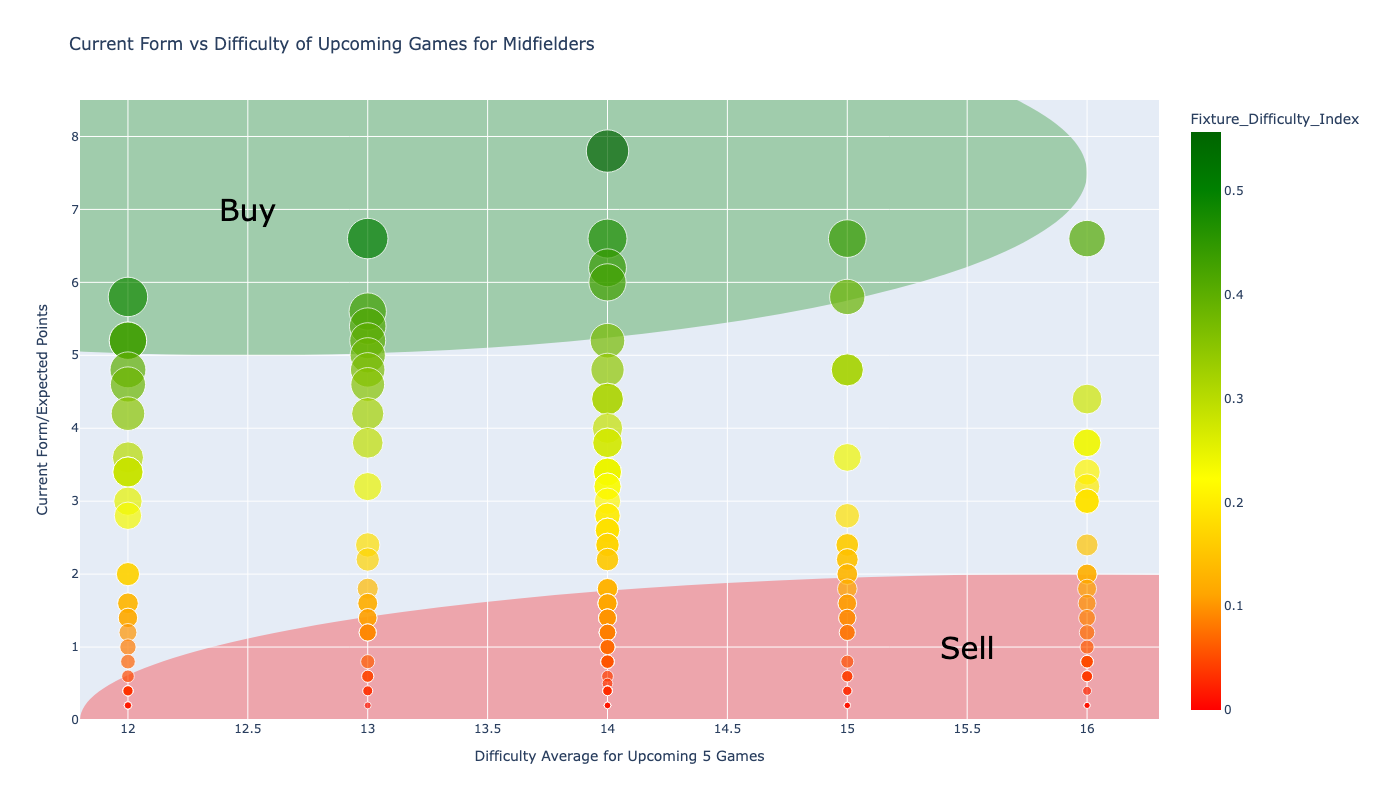

In [ ]:

# Rename 'FD_index' to 'Fixture_Difficulty_Index'. Did this here to keep main df cleaner
sorted_midfielders_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

# Wanted interactive scatter plot with hover information so that I could see the player, team, price and FD index without it being on the axis
fig = px.scatter(sorted_midfielders_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', #used to visualise quickly which is best pick
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Midfielders',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') # so I tried to get this to fade from green -buy, to red -sell, and everything else yellow and orange, sorta worked
                 ]
                )

""" Add circles and text for the suggested buy and sell regions. Couldnt find a better way to do this without installing a lot of things Im not
familar with and didn't have time to learn. Brute force did the trick though
"""
fig.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=5,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', #thought it was clear, but Esky did say to make things clearer, than not :D
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)


fig.update_layout(showlegend=False, height=800)  

# Circles were going too far out, so had to zoom in 
fig.update_xaxes(range=[11.8, 16.3])
fig.update_yaxes(range=[0, 8.5])

fig.show()


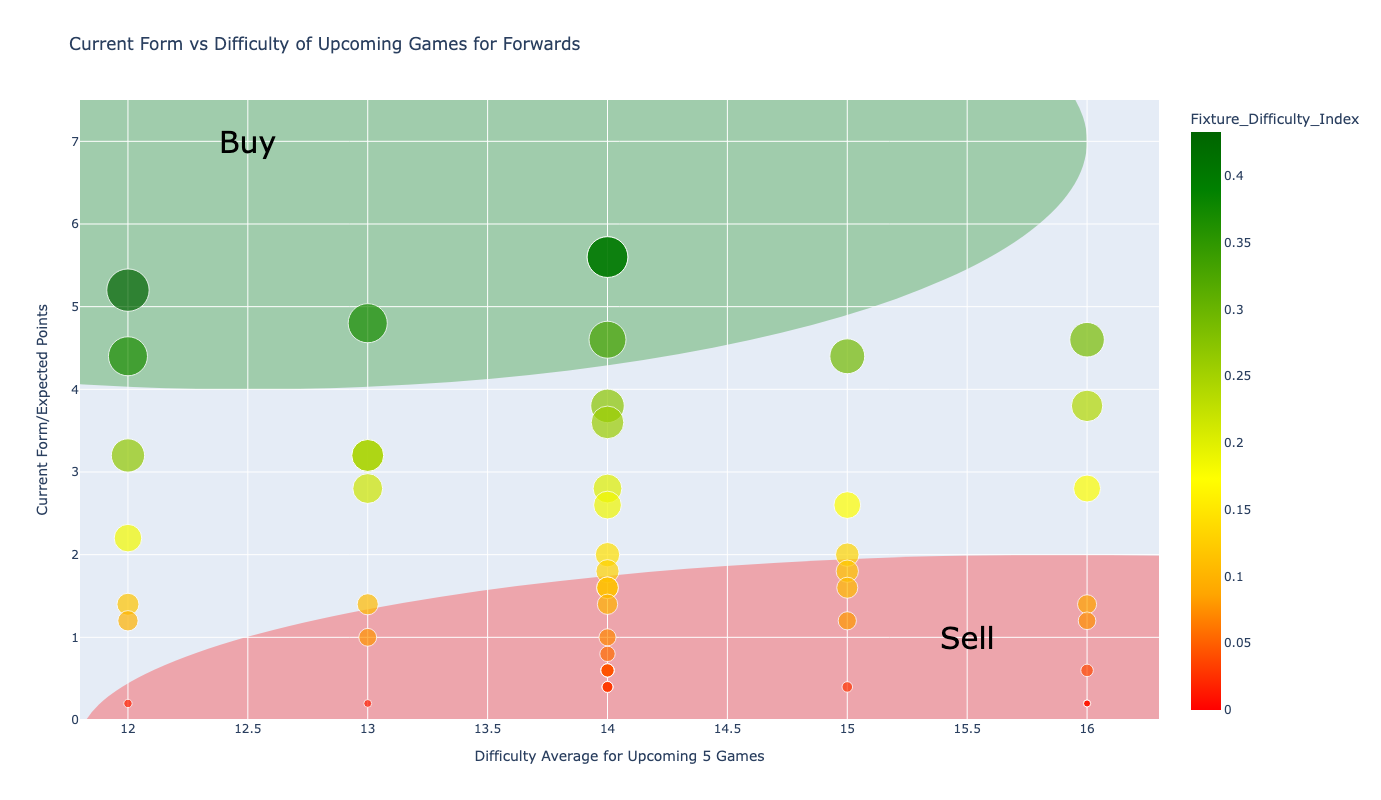

In [ ]:
# Now the same for Forwards
sorted_forwards_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)


fig = px.scatter(sorted_forwards_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Forwards',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') 
                 ]
                )

#adjusted the buy circle here as strikers have lower form ratings
fig.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2.5,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', #thought it was clear, but Eskil did say to make things clearer, than not :D
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)


fig.update_layout(showlegend=False, height=800)  

# Circles were going too far out, so had to zoom in 
fig.update_xaxes(range=[11.8, 16.3])
fig.update_yaxes(range=[0, 7.5])

fig.show()


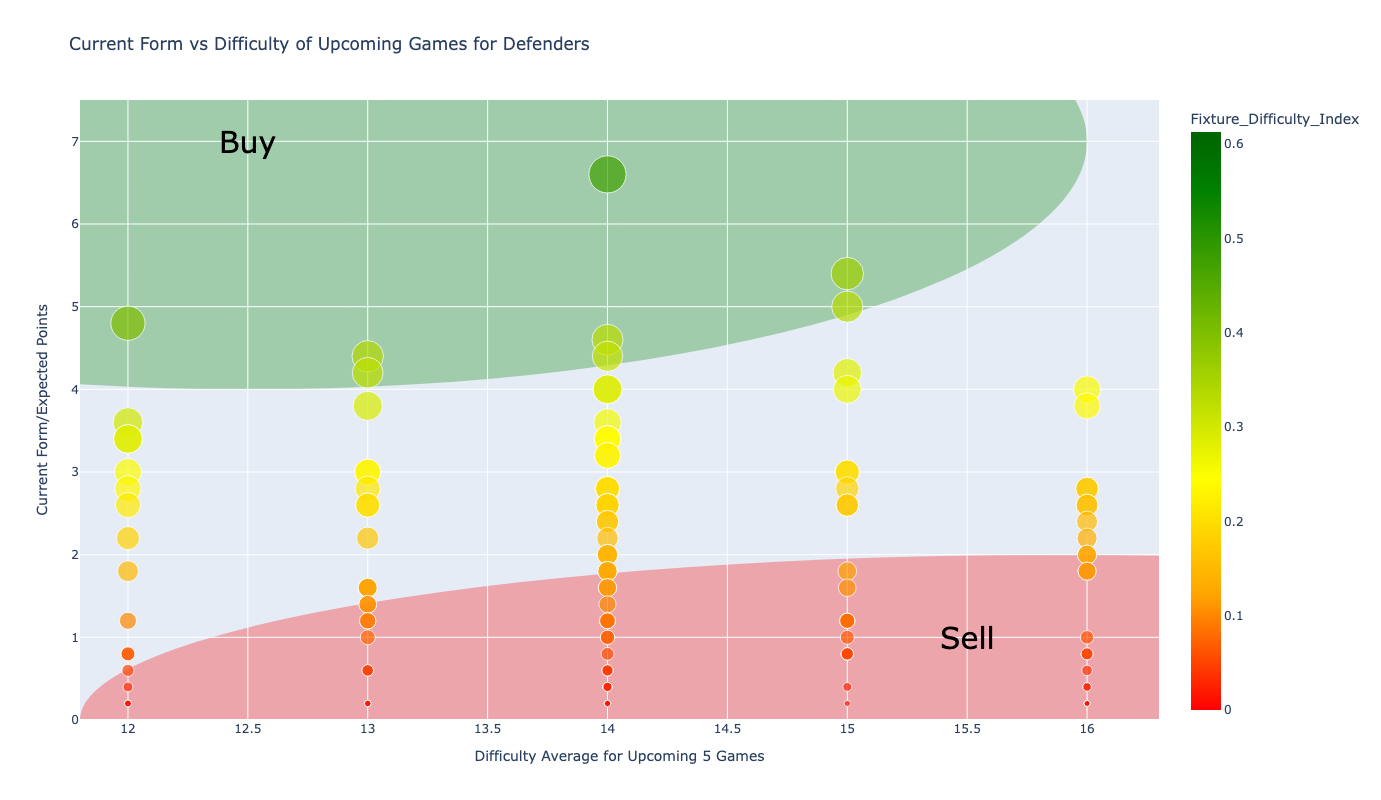

In [ ]:

# Rename 'FD_index' to 'Fixture_Difficulty_Index'. Did this here to keep main df cleaner
positive_defenders_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

# Create the scatter plot for defenders
fig_defenders = px.scatter(positive_defenders_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                           size='Fixture_Difficulty_Index',  
                           labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                           hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Defenders',
                           size_max=30,  
                           color_continuous_scale=[
                               (0.0, 'red'),
                               (0.2, 'orange'),
                               (0.4, 'yellow'),
                               (0.9, 'green'),
                               (1.0, 'darkgreen') 
                           ]
                          )

# Adjusted the buy circle here as defenders may have different form ratings
fig_defenders.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy',
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)

fig_defenders.update_layout(showlegend=False, height=800)  

# Circles were going too far out, so had to zoom in 
fig_defenders.update_xaxes(range=[11.8, 16.3])
fig_defenders.update_yaxes(range=[0, 7.5])

fig_defenders.show()


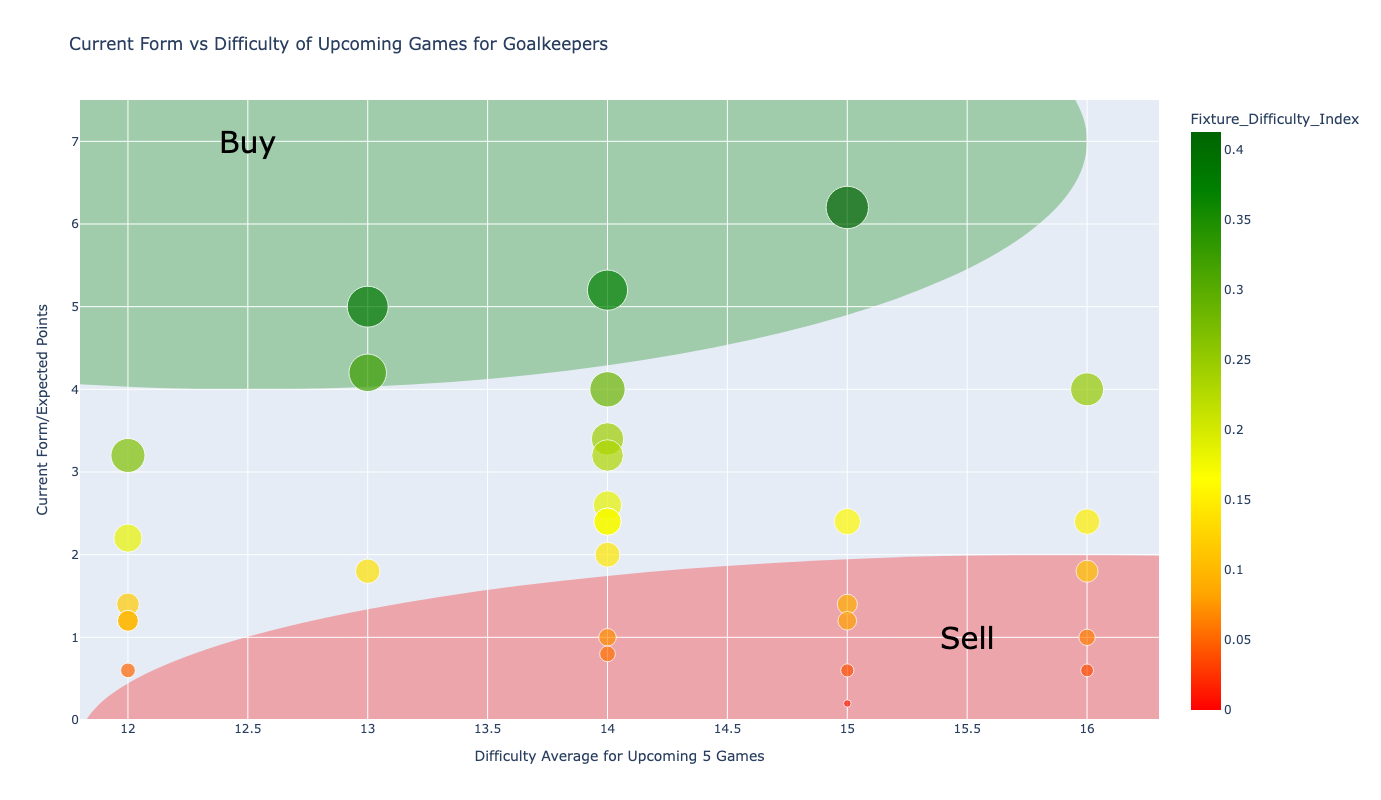

In [ ]:
# Now the same for Goalkeepers
sorted_goalkeepers_df.rename(columns={'FD_index': 'Fixture_Difficulty_Index'}, inplace=True)

fig_goalkeepers = px.scatter(sorted_goalkeepers_df, x='Difficulty_score', y='form_player', color='Fixture_Difficulty_Index', 
                 size='Fixture_Difficulty_Index',  
                 labels={'form_player': 'Current Form/Expected Points', 'Difficulty_score': 'Difficulty Average for Upcoming 5 Games'},
                 hover_data=['full_name', 'Fixture_Difficulty_Index', 'name', 'now_cost'], title='Current Form vs Difficulty of Upcoming Games for Goalkeepers',
                 size_max=30,  
                 color_continuous_scale=[
                    (0.0, 'red'),
                    (0.2, 'orange'),
                    (0.4, 'yellow'),
                    (0.9, 'green'),
                    (1.0, 'darkgreen') 
                 ]
                )

# Adjusted the buy circle here as goalkeepers may have different form ratings
fig_goalkeepers.update_layout(
    shapes=[
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=9,
            y0=10,
            x1=16,
            y1=4,
            fillcolor='green',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        ),
        dict(
            type='circle',
            xref='x',
            yref='y',
            x0=11.8,
            y0=2,
            x1=20,
            y1=-2.5,
            fillcolor='red',
            opacity=0.3,
            layer='below',
            line=dict(width=0),
        )
    ],
    annotations=[
        dict(
            text='Buy', # thought it was clear, but Eskil did say to make things clearer, than not :D
            x=12.5,  
            y=7,   
            showarrow=False,
            font=dict(color='black', size=30),
        ),
        dict(
            text='Sell',
            x=15.5,  
            y=1,   
            showarrow=False,
            font=dict(color='black', size=30),
        )
    ]
)

fig_goalkeepers.update_layout(showlegend=False, height=800)  

# Circles were going too far out, so had to zoom in   
fig_goalkeepers.update_xaxes(range=[11.8, 16.3])
fig_goalkeepers.update_yaxes(range=[0, 7.5])

fig_goalkeepers.show()
